In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from fem_1d import *
from qva import *
from pauliDecomp import *
from scipy.sparse import diags
import pprint
pp = pprint.PrettyPrinter(width=110, compact=True)

##############################################
##############################################
# Analytic Solutions
def u_cubic(x):
    return (-x**3+x**2+x+1)

def u_quadratic(x):
    xo = 1/2
    g  = 0
    b_analytic1 = 1/np.sqrt(4)  # choose this so that an 3bit RHS is already normalized
    b_coeff  = -(1/2)*b_analytic1 # gives k = 1/sqrt(8)
    a = g - b_coeff*(-xo)**2
    return (a + b_coeff*(x - xo)**2)

def u_heat(x,t):
    return (1./np.sqrt(4. * np.pi * t)) * np.exp(-pow(x-0.5,2)/(4.0 * t))


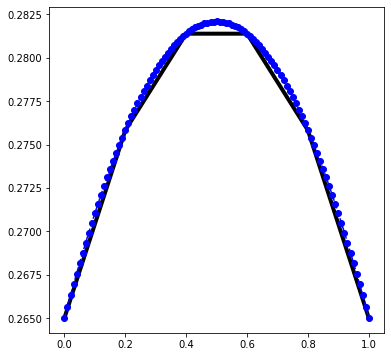

iteration:  1  || cost:  0.9574687356547074
iteration:  2  || cost:  0.9485253650255883
iteration:  3  || cost:  0.98477258357388
iteration:  4  || cost:  0.9637451830166742
iteration:  5  || cost:  0.8916603140435554
iteration:  6  || cost:  0.8615020176941061
iteration:  7  || cost:  0.7859256434677069
iteration:  8  || cost:  0.6230587100724048


In [ ]:
# Heat Equation Solve
nqbits = 2 #3 #2
nlayers = 3#. 6 #3
maxiter = 200 #2000 #200
reduced = 1
method = "COBYLA"
rhobeg = np.pi/10.0

# Define and Solve the FEM Problem
xl = 0; xr = 1; nx = 2**(nqbits) + 2;
tl = 1; tr = 3; nt = 11
u_analytic, x, t, M, A, dt, h = heat_solve(xl,xr,nx,tl,tr,nt,reduced,u_heat)  # returns reduced matrices, but x is full

# Initial QVA Parameters
random.seed()
nparameters = nqbits + 2*(nqbits-1)*(nlayers-1)
parameters = [float(random.randint(-3100,3100))/1000 for i in range(0, nparameters)]

# Get FEM Matrix Pauli Decomposition
result = pauli_decomp(nqbits,A,Pauli,Pauli_Names,nPauli)
c = []; g = []; 
for i in range(len(result)):
    gt = [None] * nqbits
    for j in range(nqbits):
        gt[nqbits-j - 1] = result[i][2][j]
    c.append(result[i][0])
    g.append(gt)


# 2 qbit Heat Equation
#parameters = [-0.271168, -1.418207,  3.262556, -3.699268, -1.848239,  2.757174]
#g = [[0, 0],[0, 1],[1, 1],[2, 2]]
#c = [2.13333333333333, -0.966666666666667, -0.483333333333333,-0.483333333333333]

u = u_heat(x,tl)
u_store = []; cost_values_store = [];
u_store.append(u.tolist())

h,x = create_grid(nx,xl,xr)
hh,xp = create_grid(101,xl,xr)
fig = plt.figure(figsize=(6, 6),facecolor=(1, 1, 1))
plt.plot(x,u,color="black",linewidth=4.0,label='Discrete Solution')
plt.plot(xp,u_heat(xp,tl),color="blue",linestyle='--',marker='o',label='Analytic Solution')
plt.show()

for n1 in range(nt):
    time = tl + n1 * dt + dt # t^(n+1)
    
    # boundary conditions and scaling values
    ul = u_heat(xl,time)
    ur = u_heat(xr,time)
    uscale = u_heat(x[1],time)

    # calculate RHS
    if reduced == 1:
        b = np.matmul(M,u[1:nx-1])
        b[0] = b[0] + M[0,1] * u_heat(xl,tl) - A[0,1] * ul
        b[nx-3] = b[nx-3] + M[0,1] * u_heat(xr,tl) - A[0,1] * ur
    else:
        u_old = u_heat(x,tl)
        b = np.matmul(M,u)
        b[0] = ul
        b[n-1] = ur

    #############################################################################################################
    #nit = 0
    #cost_values = []
    u, parameters, cost_values = run_qva(nqbits,nlayers,maxiter,c,g,b,parameters,method,rhobeg,ul,ur,uscale,reduced)
    #############################################################################################################

    cost_values_store.append(cost_values)
    u_store.append(u.tolist())
    
    fig = plt.figure(figsize=(6, 6),facecolor=(1, 1, 1))
    plt.plot(x,u,color="black",linewidth=4.0,label='Discrete Solution')
    plt.plot(xp,u_heat(xp,time),color="blue",linestyle='--',marker='o',label='Analytic Solution')
    plt.show()
    

In [ ]:
# Plot the results
fig = plt.figure(figsize=(12, 18),facecolor=(1, 1, 1))
nrows = 4
ncols = 3
gs = fig.add_gridspec(nrows,ncols)
count = 0
for i in range(nrows):
    for j in range(ncols):
        ax = fig.add_subplot(gs[i, j])
        time = tl + count * dt
        ax.plot(x,u_store[count],color="black",linestyle='--',marker='o',markersize=15,markerfacecolor='none',linewidth=1.0,label='Discrete Solution')
        ax.plot(xp,u_heat(xp,tl+dt*count),color="black",label='Analytic Solution')
        if count==0 or count==3 or count==6 or count==9:
            ax.set_ylabel("f(x,t)", fontsize=18)
        #ax.set_xlabel("x", fontsize=12)
        ax.grid()
        ax.set_ylim([min(min(u_store)),max(max(u_store))+0.01])
        ax.text(0.5, max(max(u_store))+0.015,'time: %.1fs'%(time),color="black",fontsize=18,ha='center')
        count = count + 1
        if count == nt:
            break
#plt.savefig("/Users/corey/Dropbox/QUANTUM_COMPUTING/NEW_CODE/package/images/heat_solution_3q.png",dpi=300,format='png',bbox_inches='tight')
plt.show()

In [ ]:
tt = np.zeros(nt)
it = np.zeros(nt)
for i in range(0,nt):
    tt[i] = tl + i*dt
    it[i] = len(cost_values_store[i])
    
fig = plt.figure(figsize=(8, 6),facecolor=(1, 1, 1))
plt.plot(tt,it,"o-",ms=14, color='black')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("iteration count", fontsize=20)
plt.xlabel("time(s)", fontsize=18)
plt.grid()
#fname = "/Users/corey/Desktop/Quantum_Notebooks/paper_results/final_plots/fe_vqls_3qbit_iteration_count.png"
plt.savefig(fname,dpi=300,format='png',bbox_inches='tight')
plt.show()

nqbits:  3
A:  [[ 2. -1. -0. -0. -0. -0. -0. -0.]
 [-1.  2. -1. -0. -0. -0. -0. -0.]
 [-0. -1.  2. -1. -0. -0. -0. -0.]
 [-0. -0. -1.  2. -1. -0. -0. -0.]
 [-0. -0. -0. -1.  2. -1. -0. -0.]
 [-0. -0. -0. -0. -1.  2. -1. -0.]
 [-0. -0. -0. -0. -0. -1.  2. -1.]
 [-0. -0. -0. -0. -0. -0. -1.  2.]]
A_PD:  Matrix([[2.00000000000000, -1.00000000000000, 0, 0, 0, 0, 0, 0], [-1.00000000000000, 2.00000000000000, -1.00000000000000, 0, 0, 0, 0, 0], [0, -1.00000000000000, 2.00000000000000, -1.00000000000000, 0, 0, 0, 0], [0, 0, -1.00000000000000, 2.00000000000000, -1.00000000000000, 0, 0, 0], [0, 0, 0, -1.00000000000000, 2.00000000000000, -1.00000000000000, 0, 0], [0, 0, 0, 0, -1.00000000000000, 2.00000000000000, -1.00000000000000, 0], [0, 0, 0, 0, 0, -1.00000000000000, 2.00000000000000, -1.00000000000000], [0, 0, 0, 0, 0, 0, -1.00000000000000, 2.00000000000000]])
PauliDecomp:  [[2.00000000000000, 'III', [0, 0, 0]], [-1.00000000000000, 'IIX', [0, 0, 1]], [-0.500000000000000, 'IXX', [0, 1, 1]], [-0.

iteration:  141  || cost:  0.11403431691455035
iteration:  142  || cost:  0.11255907406922194
iteration:  143  || cost:  0.11525915968059852
iteration:  144  || cost:  0.11197650920631219
iteration:  145  || cost:  0.11261485822959139
iteration:  146  || cost:  0.11186762136503292
iteration:  147  || cost:  0.11317559241211561
iteration:  148  || cost:  0.11304093859345021
iteration:  149  || cost:  0.1123488312466252
iteration:  150  || cost:  0.11179183038346219
iteration:  151  || cost:  0.11449108111536344
iteration:  152  || cost:  0.11196424990926679
iteration:  153  || cost:  0.113144402617944
iteration:  154  || cost:  0.11240704967285686
iteration:  155  || cost:  0.1121064410135717
iteration:  156  || cost:  0.1133832812207538
iteration:  157  || cost:  0.11169388762814325
iteration:  158  || cost:  0.11215708630628118
iteration:  159  || cost:  0.11191447587463921
iteration:  160  || cost:  0.11246911378125635
iteration:  161  || cost:  0.11191906420382514
iteration:  162  |

iteration:  316  || cost:  0.10424770257750238
iteration:  317  || cost:  0.1041742172535498
iteration:  318  || cost:  0.10418569267050326
iteration:  319  || cost:  0.10396140794708275
iteration:  320  || cost:  0.10384251124945976
iteration:  321  || cost:  0.10380638486844318
iteration:  322  || cost:  0.10381313014310456
iteration:  323  || cost:  0.10373243864825521
iteration:  324  || cost:  0.10364335481508014
iteration:  325  || cost:  0.10345022572474116
iteration:  326  || cost:  0.10333938540702214
iteration:  327  || cost:  0.1035372418270889
iteration:  328  || cost:  0.10327226062765216
iteration:  329  || cost:  0.1029542772709301
iteration:  330  || cost:  0.1028774930438795
iteration:  331  || cost:  0.10289222395893227
iteration:  332  || cost:  0.10288583553867425
iteration:  333  || cost:  0.10289634810899406
iteration:  334  || cost:  0.10286200300539827
iteration:  335  || cost:  0.10285846734525228
iteration:  336  || cost:  0.10285708882441302
iteration:  337  

iteration:  491  || cost:  0.09407645525045816
iteration:  492  || cost:  0.09393326251529233
iteration:  493  || cost:  0.09397803740704469
iteration:  494  || cost:  0.09394567765458228
iteration:  495  || cost:  0.09397239822132109
iteration:  496  || cost:  0.09393210131255547
iteration:  497  || cost:  0.09396299504390071
iteration:  498  || cost:  0.09395911285802094
iteration:  499  || cost:  0.09396164464272272
iteration:  500  || cost:  0.0937493225115934
iteration:  501  || cost:  0.09358172473928239
iteration:  502  || cost:  0.09353022905940434
iteration:  503  || cost:  0.09356205142657337
iteration:  504  || cost:  0.09354244569470849
iteration:  505  || cost:  0.09356549397210312
iteration:  506  || cost:  0.09349672279969079
iteration:  507  || cost:  0.09335293038586845
iteration:  508  || cost:  0.09336802138863609
iteration:  509  || cost:  0.09349738598595925
iteration:  510  || cost:  0.09316411965117921
iteration:  511  || cost:  0.093020369691592
iteration:  512 

iteration:  666  || cost:  0.08445731771569509
iteration:  667  || cost:  0.08437970598870803
iteration:  668  || cost:  0.08434928459041302
iteration:  669  || cost:  0.08434571996247198
iteration:  670  || cost:  0.08430990760808765
iteration:  671  || cost:  0.08427377921335355
iteration:  672  || cost:  0.08439372151072833
iteration:  673  || cost:  0.08429134197933408
iteration:  674  || cost:  0.08418477521893897
iteration:  675  || cost:  0.08415579976469156
iteration:  676  || cost:  0.0839074365523278
iteration:  677  || cost:  0.08392084598708782
iteration:  678  || cost:  0.08383520946939693
iteration:  679  || cost:  0.08391132176483618
iteration:  680  || cost:  0.08372153712573127
iteration:  681  || cost:  0.08359062197938316
iteration:  682  || cost:  0.08385573995919993
iteration:  683  || cost:  0.08318888499418586
iteration:  684  || cost:  0.08286849859394763
iteration:  685  || cost:  0.08276529258775267
iteration:  686  || cost:  0.08270848008957865
iteration:  68

iteration:  841  || cost:  0.0744706013953167
iteration:  842  || cost:  0.07437727675290073
iteration:  843  || cost:  0.07448348397707727
iteration:  844  || cost:  0.07434214107442261
iteration:  845  || cost:  0.074354206100685
iteration:  846  || cost:  0.07435167504629803
iteration:  847  || cost:  0.07428049515931867
iteration:  848  || cost:  0.07428548277238567
iteration:  849  || cost:  0.07437587742845087
iteration:  850  || cost:  0.07425843702725943
iteration:  851  || cost:  0.07438168975475778
iteration:  852  || cost:  0.0742476478084041
iteration:  853  || cost:  0.07425959527291848
iteration:  854  || cost:  0.07422862062059576
iteration:  855  || cost:  0.0738266696890808
iteration:  856  || cost:  0.0738009304474685
iteration:  857  || cost:  0.07383328069935124
iteration:  858  || cost:  0.07371659933155672
iteration:  859  || cost:  0.07381611516686959
iteration:  860  || cost:  0.07355636669544574
iteration:  861  || cost:  0.07351867698565939
iteration:  862  ||

iteration:  1016  || cost:  0.06316060975420112
iteration:  1017  || cost:  0.06319523550370665
iteration:  1018  || cost:  0.06318573583269826
iteration:  1019  || cost:  0.06315412244441576
iteration:  1020  || cost:  0.06313396951331274
iteration:  1021  || cost:  0.0632311621415299
iteration:  1022  || cost:  0.06311358468205441
iteration:  1023  || cost:  0.06360831496141672
iteration:  1024  || cost:  0.06292183307871779
iteration:  1025  || cost:  0.06269166561320705
iteration:  1026  || cost:  0.06269219474178522
iteration:  1027  || cost:  0.06270335755821332
iteration:  1028  || cost:  0.06280739809158487
iteration:  1029  || cost:  0.06267157496855047
iteration:  1030  || cost:  0.06312231967706705
iteration:  1031  || cost:  0.06258072369506629
iteration:  1032  || cost:  0.0623036789636332
iteration:  1033  || cost:  0.0625227485966593
iteration:  1034  || cost:  0.06239969700211723
iteration:  1035  || cost:  0.062299574148025005
iteration:  1036  || cost:  0.062326314623

iteration:  1187  || cost:  0.05447127361226323
iteration:  1188  || cost:  0.05429161441897923
iteration:  1189  || cost:  0.053538532799792815
iteration:  1190  || cost:  0.05341750560324643
iteration:  1191  || cost:  0.053383426276756185
iteration:  1192  || cost:  0.05372122990255224
iteration:  1193  || cost:  0.05342749343264541
iteration:  1194  || cost:  0.05347973576284504
iteration:  1195  || cost:  0.05336323349974614
iteration:  1196  || cost:  0.053387024986845555
iteration:  1197  || cost:  0.05342414069375623
iteration:  1198  || cost:  0.05334726268827883
iteration:  1199  || cost:  0.053393662404537356
iteration:  1200  || cost:  0.053628800964303225
iteration:  1201  || cost:  0.053488597192417386
iteration:  1202  || cost:  0.05298058590412724
iteration:  1203  || cost:  0.05304140531939805
iteration:  1204  || cost:  0.05293777686567369
iteration:  1205  || cost:  0.05305453330147303
iteration:  1206  || cost:  0.052872486818927644
iteration:  1207  || cost:  0.052

iteration:  1357  || cost:  0.043495381627766116
iteration:  1358  || cost:  0.04339908564007666
iteration:  1359  || cost:  0.04361657801209684
iteration:  1360  || cost:  0.04321625942576035
iteration:  1361  || cost:  0.043234082249489325
iteration:  1362  || cost:  0.04320025007529327
iteration:  1363  || cost:  0.043180047371312535
iteration:  1364  || cost:  0.04345768419247753
iteration:  1365  || cost:  0.04308099143653965
iteration:  1366  || cost:  0.043216514697647535
iteration:  1367  || cost:  0.04302823588289684
iteration:  1368  || cost:  0.04313599732722295
iteration:  1369  || cost:  0.043045811851296856
iteration:  1370  || cost:  0.04275471314650636
iteration:  1371  || cost:  0.042628299972780614
iteration:  1372  || cost:  0.042857935121284996
iteration:  1373  || cost:  0.04240899806557208
iteration:  1374  || cost:  0.04250668929723378
iteration:  1375  || cost:  0.04278934415762348
iteration:  1376  || cost:  0.04233979584322789
iteration:  1377  || cost:  0.042

iteration:  1527  || cost:  0.03229578706907554
iteration:  1528  || cost:  0.03215604447602427
iteration:  1529  || cost:  0.03202964786577733
iteration:  1530  || cost:  0.03201617303003823
iteration:  1531  || cost:  0.0319839857081885
iteration:  1532  || cost:  0.032017715223725984
iteration:  1533  || cost:  0.03202846308788532
iteration:  1534  || cost:  0.0324898498526669
iteration:  1535  || cost:  0.031904917247014275
iteration:  1536  || cost:  0.032172771222438334
iteration:  1537  || cost:  0.032459058598019785
iteration:  1538  || cost:  0.031319062023808186
iteration:  1539  || cost:  0.03140503664424188
iteration:  1540  || cost:  0.031277294310218196
iteration:  1541  || cost:  0.031473184055547665
iteration:  1542  || cost:  0.03136785377094842
iteration:  1543  || cost:  0.031260504686662194
iteration:  1544  || cost:  0.03123019414770134
iteration:  1545  || cost:  0.03129857729762331
iteration:  1546  || cost:  0.0312739135490987
iteration:  1547  || cost:  0.03170

iteration:  1696  || cost:  0.023462079865199437
iteration:  1697  || cost:  0.023467611337971372
iteration:  1698  || cost:  0.023520113547536248
iteration:  1699  || cost:  0.02344670266727278
iteration:  1700  || cost:  0.02356817217640872
iteration:  1701  || cost:  0.023268957603937546
iteration:  1702  || cost:  0.023011020325103382
iteration:  1703  || cost:  0.023003833621766945
iteration:  1704  || cost:  0.023028330103050942
iteration:  1705  || cost:  0.02299001568607617
iteration:  1706  || cost:  0.023009802581597127
iteration:  1707  || cost:  0.023016881641445552
iteration:  1708  || cost:  0.02296258540481333
iteration:  1709  || cost:  0.023046841933541895
iteration:  1710  || cost:  0.022971288160201886
iteration:  1711  || cost:  0.023181453802394225
iteration:  1712  || cost:  0.02292356894699432
iteration:  1713  || cost:  0.022823816256282825
iteration:  1714  || cost:  0.022751524422223057
iteration:  1715  || cost:  0.022930469041052004
iteration:  1716  || cost

iteration:  1865  || cost:  0.017818265049712068
iteration:  1866  || cost:  0.017840332787767865
iteration:  1867  || cost:  0.017753461991733666
iteration:  1868  || cost:  0.017611500744581288
iteration:  1869  || cost:  0.01749325183306849
iteration:  1870  || cost:  0.017527647868249785
iteration:  1871  || cost:  0.01747605160970578
iteration:  1872  || cost:  0.017410587867227156
iteration:  1873  || cost:  0.017427949718841096
iteration:  1874  || cost:  0.01735241826373235
iteration:  1875  || cost:  0.01723020183685553
iteration:  1876  || cost:  0.01724938403311238
iteration:  1877  || cost:  0.017213040137723845
iteration:  1878  || cost:  0.017432306309840162
iteration:  1879  || cost:  0.0168248570507612
iteration:  1880  || cost:  0.016630551251358594
iteration:  1881  || cost:  0.016624727641818327
iteration:  1882  || cost:  0.016655115185148617
iteration:  1883  || cost:  0.016539221357747547
iteration:  1884  || cost:  0.01654893908526145
iteration:  1885  || cost:  

iteration:  2034  || cost:  0.01242398957570201
iteration:  2035  || cost:  0.011913696088242887
iteration:  2036  || cost:  0.011786688313698113
iteration:  2037  || cost:  0.011758201879884855
iteration:  2038  || cost:  0.011802271327717717
iteration:  2039  || cost:  0.01195140422781582
iteration:  2040  || cost:  0.011765657394408158
iteration:  2041  || cost:  0.011805302433385956
iteration:  2042  || cost:  0.011740371046962572
iteration:  2043  || cost:  0.011916925485923713
iteration:  2044  || cost:  0.011784690753066762
iteration:  2045  || cost:  0.011758471337850795
iteration:  2046  || cost:  0.011763543842560176
iteration:  2047  || cost:  0.012072975244749706
iteration:  2048  || cost:  0.01166179063749051
iteration:  2049  || cost:  0.011475904845973162
iteration:  2050  || cost:  0.011563531452470022
iteration:  2051  || cost:  0.011548431543587756
iteration:  2052  || cost:  0.011339942150877635
iteration:  2053  || cost:  0.011364308839351134
iteration:  2054  || co

iteration:  2202  || cost:  0.007312179896838855
iteration:  2203  || cost:  0.007257975768781955
iteration:  2204  || cost:  0.0072520490737041365
iteration:  2205  || cost:  0.007194064659550747
iteration:  2206  || cost:  0.007192227345851121
iteration:  2207  || cost:  0.0071716456623937
iteration:  2208  || cost:  0.007169594926093814
iteration:  2209  || cost:  0.007233634485085294
iteration:  2210  || cost:  0.007180029807743127
iteration:  2211  || cost:  0.007161683213252279
iteration:  2212  || cost:  0.0071719047121259205
iteration:  2213  || cost:  0.007267275856283173
iteration:  2214  || cost:  0.007251709329499145
iteration:  2215  || cost:  0.00700734246122825
iteration:  2216  || cost:  0.007025400774271828
iteration:  2217  || cost:  0.0070036182334831665
iteration:  2218  || cost:  0.007004958816638318
iteration:  2219  || cost:  0.006982493478872254
iteration:  2220  || cost:  0.006982150578520585
iteration:  2221  || cost:  0.006980669000680728
iteration:  2222  ||

iteration:  2370  || cost:  0.00442682549842055
iteration:  2371  || cost:  0.004407921661844227
iteration:  2372  || cost:  0.004401446802180686
iteration:  2373  || cost:  0.004401323669416257
iteration:  2374  || cost:  0.004386207589816338
iteration:  2375  || cost:  0.004389953731022467
iteration:  2376  || cost:  0.004584111819979975
iteration:  2377  || cost:  0.0043716617999108864
iteration:  2378  || cost:  0.0043090180003392264
iteration:  2379  || cost:  0.004271527575095746
iteration:  2380  || cost:  0.00429736593470631
iteration:  2381  || cost:  0.004322097551112125
iteration:  2382  || cost:  0.0042889532253269635
iteration:  2383  || cost:  0.0043110316262674475
iteration:  2384  || cost:  0.004274850818609455
iteration:  2385  || cost:  0.0042708980612475855
iteration:  2386  || cost:  0.004255169387351931
iteration:  2387  || cost:  0.004347257789779735
iteration:  2388  || cost:  0.00426846068946507
iteration:  2389  || cost:  0.004283547985304281
iteration:  2390  

iteration:  2536  || cost:  0.002310796909020141
iteration:  2537  || cost:  0.0023058416580817864
iteration:  2538  || cost:  0.002326194662782277
iteration:  2539  || cost:  0.0022409415496414953
iteration:  2540  || cost:  0.0022439616704666987
iteration:  2541  || cost:  0.0022380407364401833
iteration:  2542  || cost:  0.002233328246144417
iteration:  2543  || cost:  0.002232107484033352
iteration:  2544  || cost:  0.0022156326604194643
iteration:  2545  || cost:  0.0022161346510808366
iteration:  2546  || cost:  0.0022241498768441614
iteration:  2547  || cost:  0.0022433184883212665
iteration:  2548  || cost:  0.002172112408264537
iteration:  2549  || cost:  0.0021493296191625877
iteration:  2550  || cost:  0.0021407016639003462
iteration:  2551  || cost:  0.0021392454665627447
iteration:  2552  || cost:  0.002123066666807283
iteration:  2553  || cost:  0.002120384742568926
iteration:  2554  || cost:  0.002123427532390254
iteration:  2555  || cost:  0.0021200552900703107
iteratio

iteration:  2702  || cost:  0.0014240587783576064
iteration:  2703  || cost:  0.0014235790667008752
iteration:  2704  || cost:  0.0014424611954437783
iteration:  2705  || cost:  0.0014194332549465338
iteration:  2706  || cost:  0.0014207169994353563
iteration:  2707  || cost:  0.0014272758260598373
iteration:  2708  || cost:  0.0014208826854564816
iteration:  2709  || cost:  0.0014189112227225298
iteration:  2710  || cost:  0.00142492843239872
iteration:  2711  || cost:  0.0014151475896069243
iteration:  2712  || cost:  0.0014156069743200828
iteration:  2713  || cost:  0.0014137003160583639
iteration:  2714  || cost:  0.0013899220121338374
iteration:  2715  || cost:  0.0014043491997486335
iteration:  2716  || cost:  0.0013905055854508408
iteration:  2717  || cost:  0.0013956314468213105
iteration:  2718  || cost:  0.0013923559393124174
iteration:  2719  || cost:  0.0013660579506022952
iteration:  2720  || cost:  0.0013837657774831147
iteration:  2721  || cost:  0.0013682329512536562
it

iteration:  2867  || cost:  0.0007319660580215048
iteration:  2868  || cost:  0.0007418377052319514
iteration:  2869  || cost:  0.0007293185528577384
iteration:  2870  || cost:  0.0007285912518574245
iteration:  2871  || cost:  0.0007242446263111546
iteration:  2872  || cost:  0.0007227601786138349
iteration:  2873  || cost:  0.0007168732757681928
iteration:  2874  || cost:  0.0007042143300518555
iteration:  2875  || cost:  0.0006964299971731203
iteration:  2876  || cost:  0.0006973817346767053
iteration:  2877  || cost:  0.0006903882263142869
iteration:  2878  || cost:  0.0006927301392252172
iteration:  2879  || cost:  0.0006897246593225992
iteration:  2880  || cost:  0.0007088557430525722
iteration:  2881  || cost:  0.0006600192439324415
iteration:  2882  || cost:  0.0006477620864892009
iteration:  2883  || cost:  0.0006390256066634015
iteration:  2884  || cost:  0.000619602713974321
iteration:  2885  || cost:  0.0006188562398204978
iteration:  2886  || cost:  0.0006125774124641215
i

iteration:  3030  || cost:  0.0002994064030493737
iteration:  3031  || cost:  0.0002991652129026301
iteration:  3032  || cost:  0.00029891799905501504
iteration:  3033  || cost:  0.0002992192147445172
iteration:  3034  || cost:  0.00029956600295233393
iteration:  3035  || cost:  0.0003018001904577794
iteration:  3036  || cost:  0.00030748018327675375
iteration:  3037  || cost:  0.0002994226699926106
iteration:  3038  || cost:  0.0002972618162810914
iteration:  3039  || cost:  0.00029679635204271637
iteration:  3040  || cost:  0.00029466368861741365
iteration:  3041  || cost:  0.00029287213900830444
iteration:  3042  || cost:  0.0002943629339609011
iteration:  3043  || cost:  0.00029250204788000556
iteration:  3044  || cost:  0.00029076519604376294
iteration:  3045  || cost:  0.00029022603622375076
iteration:  3046  || cost:  0.00029159360023056635
iteration:  3047  || cost:  0.0002932125351842174
iteration:  3048  || cost:  0.00028721893319150205
iteration:  3049  || cost:  0.000304705

iteration:  3192  || cost:  0.00015196022518804142
iteration:  3193  || cost:  0.00014897737176267078
iteration:  3194  || cost:  0.0001463014262853557
iteration:  3195  || cost:  0.00014604736653411887
iteration:  3196  || cost:  0.00014413719587358376
iteration:  3197  || cost:  0.00014514963675060777
iteration:  3198  || cost:  0.00014227763967755713
iteration:  3199  || cost:  0.00014353760509522306
iteration:  3200  || cost:  0.0001436813625219635
iteration:  3201  || cost:  0.0001413471682798484
iteration:  3202  || cost:  0.00013898069444207017
iteration:  3203  || cost:  0.00013933499511731284
iteration:  3204  || cost:  0.00013843121946444104
iteration:  3205  || cost:  0.00013877855320143517
iteration:  3206  || cost:  0.00013306595779150054
iteration:  3207  || cost:  0.00013115651339667966
iteration:  3208  || cost:  0.00013280662141457178
iteration:  3209  || cost:  0.0001308729560538513
iteration:  3210  || cost:  0.00013211743759145023
iteration:  3211  || cost:  0.00013

iteration:  3356  || cost:  6.289979142160007e-05
iteration:  3357  || cost:  6.33401903901154e-05
iteration:  3358  || cost:  6.248145547138595e-05
iteration:  3359  || cost:  6.221975677267455e-05
iteration:  3360  || cost:  6.296035283903656e-05
iteration:  3361  || cost:  6.358484205648551e-05
iteration:  3362  || cost:  6.116572669900844e-05
iteration:  3363  || cost:  5.95151108563341e-05
iteration:  3364  || cost:  5.9276547005104874e-05
iteration:  3365  || cost:  5.9743709060811057e-05
iteration:  3366  || cost:  5.965217576375803e-05
iteration:  3367  || cost:  5.900619406828955e-05
iteration:  3368  || cost:  5.843119268456043e-05
iteration:  3369  || cost:  5.855751858663272e-05
iteration:  3370  || cost:  5.884760543384271e-05
iteration:  3371  || cost:  5.8741868435574496e-05
iteration:  3372  || cost:  5.8792665184492776e-05
iteration:  3373  || cost:  5.898941581117256e-05
iteration:  3374  || cost:  5.849866952944982e-05
iteration:  3375  || cost:  5.8262959827581895e-

iteration:  3520  || cost:  3.312166723767884e-05
iteration:  3521  || cost:  3.2611382070668604e-05
iteration:  3522  || cost:  3.245720894595738e-05
iteration:  3523  || cost:  3.255487623854414e-05
iteration:  3524  || cost:  3.236515630178349e-05
iteration:  3525  || cost:  3.228927650666957e-05
iteration:  3526  || cost:  3.2675868786302686e-05
iteration:  3527  || cost:  3.234093375237279e-05
iteration:  3528  || cost:  3.226848649529046e-05
iteration:  3529  || cost:  3.228028651713899e-05
iteration:  3530  || cost:  3.308533451429341e-05
iteration:  3531  || cost:  3.231133192682645e-05
iteration:  3532  || cost:  3.230560040157204e-05
iteration:  3533  || cost:  3.2268627377263215e-05
iteration:  3534  || cost:  3.216798660987674e-05
iteration:  3535  || cost:  3.232229104044304e-05
iteration:  3536  || cost:  3.226778304743494e-05
iteration:  3537  || cost:  3.271315379693718e-05
iteration:  3538  || cost:  3.134460986609078e-05
iteration:  3539  || cost:  3.1069794043436794e

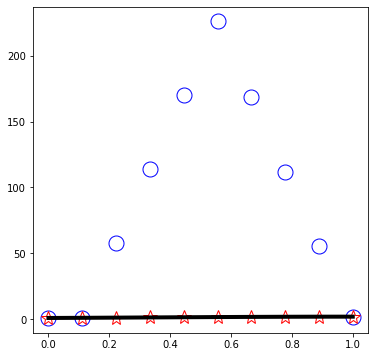

In [3]:
##################################################
##################################################
#                  Poisson Solve                 #
##################################################
##################################################
# Choose a Manufactured Solution
#case = "quadratic"; u_analytic = u_quadratic
case = "cubic"; u_analytic = u_cubic

##################################################
# Parameters
layer_range = 1
layer_start = 5
run_range = 1
nqbits = 3
maxiter = 4000
reduced = 1
method = "COBYLA"
rhobeg = np.pi#/10.0

##################################################
# Define and Solve the FEM Problem
xl = 0; xr = 1; ni = 2**(nqbits); nx = ni + 2    # TRY SHIFTING THE DOMAIN OVER BY ONE, THIS WILL FORCE ALL B ENTRIES TO BE +
h,x = create_grid(nx,xl,xr)

# Get FEM Matrix Pauli Decomposition
A = -diags([1, -2, 1], [-1, 0, 1], shape=(ni, ni)).toarray()
result = pauli_decomp(nqbits,A,Pauli,Pauli_Names,nPauli)
c = []; g = []; 
for i in range(len(result)):
    gt = [None] * nqbits
    for j in range(nqbits):
        gt[nqbits-j - 1] = result[i][2][j]
    #print("qt: ",gt)
    #print("g: ",result[i][2])
    c.append(result[i][0])
    g.append(gt)
A_PD = build_matrix_from_decomp(result)
    
print("A: ",A)
print("A_PD: ",A_PD)
print("PauliDecomp: ",result)
print("c: ",c)
print("g: ",g)

# boundary conditions and scaling values
ul = u_analytic(xl); ur = u_analytic(xr); uscale = u_analytic(x[1]);
print("ul: ",ul," || ur: ",ur)

# calculate RHS
b = np.zeros(ni)
if reduced == 1:
    if case == "quadratic":
        b[0:ni] = 1
    elif case == "cubic":   
        print("Cubic")
        b = h*h*(6*x[1:nx-1]-2) 
    b[0] = b[0] - A[0,1] * ul 
    b[ni-1] = b[ni-1] - A[0,1] * ur 
#else:
    #b = u_cubic_rhs(x)
    #b[0] = ul
    #b[n-1] = ur
print("b: ",b)
    
# Solve the discrete system
u_fem = np.zeros(nx)
u_fem[1:nx-1] = np.linalg.solve(A, b)
u_fem[0] = ua = u_analytic(xl)
u_fem[nx-1] = ua = u_analytic(xr)
print("u_fem: ",u_fem)
ht,xt = create_grid(ni+1,xl,xr)
ua = u_analytic(xt)
print("u_analytic: ",ua)

##################################################
##################################################
file = open(case + "_LayerRange_" + str(layer_range) + "_layerStart_" + str(layer_start) + "_runRange_" + str(run_range) + "_" + str(nqbits) + "qbit"".txt",'w')
for j in range(0,layer_range):
    nlayers = layer_start + j
    for i in range(0,run_range):
        print("nlayers: ",nlayers," || irun: ",i)
        
        #random.seed()
        nparameters = nqbits + 2*(nqbits-1)*(nlayers-1)
        parameters = [float(random.randint(-3100,3100))/1000 for i in range(0, nparameters)]
        
        nit = 0
        cost_values = []
        u, parameters, cost_values = run_qva(nqbits,nlayers,maxiter,c,g,b,parameters,method,rhobeg,ul,ur,uscale,reduced)
        
        # Write data to file
        file.write("nlayers %d  irun %d ncost %d nu %d\n" % (nlayers,i,len(cost_values),len(u)))
        for ii in range(0,len(cost_values)):
            file.write("%f "%cost_values[ii])
        file.write("\n")
        for ii in range(0,len(u)):
            file.write("%f "%u[ii])
        file.write("\n")
        #file.writelines("%s\n" % cost_values)
        #file.writelines("%s\n" % u)
file.close()
##################################################
##################################################
# quick plot of last run
hp,xp = create_grid(101,xl,xr)
fig = plt.figure(figsize=(6, 6),facecolor=(1, 1, 1))
plt.plot(x,u,color="blue",linestyle='none',marker='o',markersize=15,markerfacecolor='none',linewidth=1.0,label='QVA')
plt.plot(x,u_fem,color="red",linestyle='none',marker='*',markersize=15,markerfacecolor='none',linewidth=1.0,label='FEM')
plt.plot(xp,u_analytic(xp),color="black",linestyle='-',linewidth=4.0,label='Analytic Solution')
plt.show()

In [70]:
# calculate RHS
case = "cubic"; u_analytic = u_cubic
#case = "quadratic"; u_analytic = u_quadratic
reduced = 1
nqbits = 3
xl = 0; xr = 1; ni = 2**(nqbits); nx = ni + 2
h,x = create_grid(nx,xl,xr)
A = -diags([1, -2, 1], [-1, 0, 1], shape=(ni, ni)).toarray()
ul = u_analytic(xl); ur = u_analytic(xr); uscale = u_analytic(x[1]);

b = np.zeros(ni)
if reduced == 1:
    if case == "quadratic":
        b[0:ni] = 1
    elif case == "cubic":   
        #print("Cubic")
        b = h*h*(6*x[1:nx-1]-2) 
    b[0] = b[0] - A[0,1] * ul 
    b[ni-1] = b[ni-1] - A[0,1] * ur 
    
def obtain_circuit_from_vec(desired_vec,circ, qubits):
    #circ.isometry(desired_vec,qubits,[])
    controlled_gate = StatePreparation(desired_vec)
    
    circ.append(controlled_gate,qubits)
    #circ.initialize(desired_vec,qubits)
    circ = circ.decompose().decompose().decompose().decompose()
    circ = transpile(circ,basis_gates=['rx','ry','rz', 'h', 'cx'])#basis_gates=['u1', 'u2', 'u3', 'cx'])
    return circ

def swap_gates(a,control,new_circ):
    #coded for basis_gates=['rx','ry','rz', 'h', 'cx']
    if a[0].name == 'rx':
        new_name ='crx'
        new_bits = [control,a[1][0].index]
        new_circ.crx(a[0].params[0],new_bits[0],new_bits[1])
    elif a[0].name == 'ry':
        new_name ='cry'
        new_bits = [control,a[1][0].index]
        new_circ.cry(a[0].params[0],new_bits[0],new_bits[1])
    elif a[0].name == 'rz':
        new_name= 'crz'
        new_bits = [control,a[1][0].index]
        new_circ.crz(a[0].params[0],new_bits[0],new_bits[1])
    elif a[0].name == 'h':
        new_name = 'ch'
        new_bits = [control,a[1][0].index]
        new_circ.ch(a[0].params[0],new_bits[0],new_bits[1])
    elif a[0].name == 'cx':
        new_name = 'ccx'
        new_bits = [control,a[1][0].index,a[1][1].index]
        new_circ.ccx(new_bits[0],new_bits[1],new_bits[2])
    return new_name, new_bits

def Ph(quantum_circuit, theta, qubit,control_bit):
    quantum_circuit.cu1(theta,control_bit, qubit)
    quantum_circuit.cx(control_bit,qubit)
    quantum_circuit.cu1(theta,control_bit, qubit)
    quantum_circuit.cx(control_bit,qubit)
    return 0

def control_version(circ,new_circ,control_bit):
    #global phase shift
    #Ph(new_circ,circ.global_phase,1,control_bit)
    
    for a in circ:
        new_name,new_bits = swap_gates(a,control_bit,new_circ)
        #my_gate = Gate(name=new_name, num_qubits=a[0].num_qubits+1,  params=a[0].params)
        #new_circ.append(my_gate, new_bits)
    #new_circ = new_circ.inverse()
    return new_circ

def control_b(circ,auxilary,qubits,input_circ):
    #nq = circ.num_qubits
    circ=circ.compose(input_circ)
    return circ

print(b)

# Normalize this vector
b = b/np.linalg.norm(b)
b = np.array(b,dtype=complex)
    
aux = 0
qubitsRHS = [1]
for i in range(1,nqbits):
    qubitsRHS.append(i+1)
    
# Get a circuit that takes 0 state and gives the  vector
automated_circ = QuantumCircuit(nqbits+1)
automated_circ = obtain_circuit_from_vec(b,automated_circ,qubitsRHS)
circ_RHS = QuantumCircuit(nqbits+1)
circ_RHS.x(aux)
circ_RHS = control_version(automated_circ,circ_RHS,aux)
print("b_normalized: ",b)
#circ_RHS.draw(output='mpl')

# TEST 
backend = Aer.get_backend('aer_simulator')
circ_RHS.save_statevector()
t_circ = transpile(circ_RHS, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)
result = job.result()
o = result.get_statevector(circ_RHS, decimals=6)
k = 0
for l in range (0, len(o)):
    if (l%2 == 1): # first bit is control
        print("analytic: ",b[k]," quantum: ",o[l])
        k = k + 1
circ_RHS.draw(output='mpl')
print(sqrt(o[l]*conjugate(o[l])))

[ 0.98353909 -0.00823045  0.          0.00823045  0.01646091  0.02469136
  0.03292181  2.04115226]
b_normalized:  [ 0.43399989+0.j -0.0036318 +0.j  0.        +0.j  0.0036318 +0.j
  0.0072636 +0.j  0.01089539+0.j  0.01452719+0.j  0.90068596+0.j]
analytic:  (0.4339998901495139+0j)  quantum:  (0.400964-0.166085j)
analytic:  (-0.003631798243928987+0j)  quantum:  (-0.003355+0.00139j)
analytic:  0j  quantum:  (-0+0j)
analytic:  (0.003631798243928986+0j)  quantum:  (0.003355-0.00139j)
analytic:  (0.007263596487857974+0j)  quantum:  (0.006711-0.00278j)
analytic:  (0.01089539473178696+0j)  quantum:  (0.010066-0.004169j)
analytic:  (0.014527192975715943+0j)  quantum:  (0.013421-0.005559j)
analytic:  (0.9006859644943888+0j)  quantum:  (0.832125-0.344678j)


<ipython-input-70-5a8e97c586b9>:39: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  new_bits = [control,a[1][0].index]
<ipython-input-70-5a8e97c586b9>:43: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  new_bits = [control,a[1][0].index]
<ipython-input-70-5a8e97c586b9>:51: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  new_bits = [control,a[1][0].index,a[1][1].index]


sqrt((0.832125 - 0.344678*I)*(0.832125 + 0.344678*I))


Statevector([ 0.43399989+0.j, -0.0036318 -0.j, -0.        +0.j,
              0.0036318 +0.j,  0.0072636 +0.j,  0.01089539+0.j,
              0.01452719+0.j,  0.90068596+0.j],
            dims=(2, 2, 2))
b_normalized:  [ 0.43399989+0.j -0.0036318 +0.j  0.        +0.j  0.0036318 +0.j
  0.0072636 +0.j  0.01089539+0.j  0.01452719+0.j  0.90068596+0.j]
Statevector([ 0.43399989-0.j, -0.0036318 -0.j, -0.        -0.j,
              0.0036318 +0.j,  0.0072636 -0.j,  0.01089539-0.j,
              0.01452719+0.j,  0.90068596-0.j],
            dims=(2, 2, 2))
b_normalized:  [ 0.43399989+0.j -0.0036318 +0.j  0.        +0.j  0.0036318 +0.j
  0.0072636 +0.j  0.01089539+0.j  0.01452719+0.j  0.90068596+0.j]


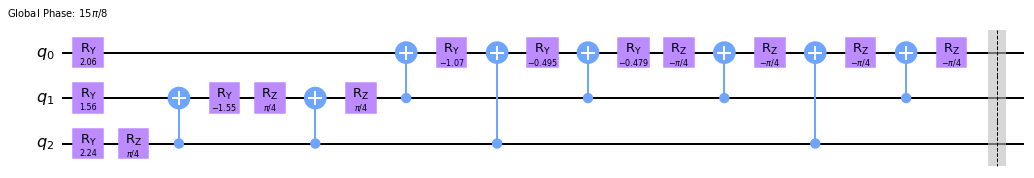

In [75]:
qubits = []
for i in range(0,nqbits):
    qubits.append(i)
    
# Get a circuit that takes 0 state and gives the  vector
circ_RHS = QuantumCircuit(nqbits)
circ_RHS = obtain_circuit_from_vec(b,circ_RHS,qubits)

#circ_RHS.draw(output='mpl')

# TEST 
backend = Aer.get_backend('aer_simulator')
circ_RHS.save_statevector()
t_circ = transpile(circ_RHS, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)
result = job.result()
o = result.get_statevector(circ_RHS, decimals=10)
#for l in range (0, len(o)):
#    if (l%2 == 1): # first bit is control
#        pp.pprint(o[l])
print(o)
print("b_normalized: ",b)
circ_RHS.draw(output='mpl')

# TEST 
# Get a circuit that takes 0 state and gives the  vector
circ_RHS = QuantumCircuit(nqbits)
circ_RHS = obtain_circuit_from_vec(np.conj(b).T,circ_RHS,qubits)
#circ_RHS = circ_RHS.adjoint()

backend = Aer.get_backend('aer_simulator')
circ_RHS.save_statevector()
t_circ = transpile(circ_RHS, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)
result = job.result()
o = result.get_statevector(circ_RHS, decimals=10)
#for l in range (0, len(o)):
#    if (l%2 == 1): # first bit is control
#        pp.pprint(o[l])
print(o)
print("b_normalized: ",b)
circ_RHS.draw(output='mpl')